In [100]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


destination = "../data/raw"
dataset_name = "nyc-yellow-taxi-trip-records-january-2024"
dataset_dir = os.path.join(destination, dataset_name)

files = os.listdir(dataset_dir)
csv_path = r"/".join([destination, dataset_name, files[0]])
df = pd.read_csv(csv_path)
#df.head(10)
df.describe().round(2).T


C:\Users\User\AppData\Local\Temp\ipykernel_16776\4273402750.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,count,mean,std,min,25%,50%,75%,max
VendorID,2964624.0,1.75,0.43,1.00,2.00,2.00,2.00,6.00
passenger_count,2824462.0,1.34,0.85,0.00,1.00,1.00,1.00,9.00
trip_distance,2964624.0,3.65,225.46,0.00,1.00,1.68,3.11,312722.30
RatecodeID,2824462.0,2.07,9.82,1.00,1.00,1.00,1.00,99.00
PULocationID,2964624.0,166.02,63.62,1.00,132.00,162.00,234.00,265.00
DOLocationID,2964624.0,165.12,69.32,1.00,114.00,162.00,234.00,265.00
payment_type,2964624.0,1.16,0.58,0.00,1.00,1.00,1.00,4.00
fare_amount,2964624.0,18.18,18.95,-899.00,8.60,12.80,20.50,5000.00
extra,2964624.0,1.45,1.80,-7.50,0.00,1.00,2.50,14.25
mta_tax,2964624.0,0.48,0.12,-0.50,0.50,0.50,0.50,4.00


# 💎 Advanced Data Polishing & Outlier Removal

In this stage, we refine the dataset by applying official NYC TLC standards and dynamic statistical filtering. This process ensures the data is logically consistent and free from extreme anomalies that could skew future analysis.

###  Polishing & Cleaning Logic:
* **Logical Validation:** Ensuring `fare_amount`, `trip_distance`, and `passenger_count` are strictly positive ($> 0$).
* **Non-Negative Fees:** Verifying `tip_amount` and `extra` charges are $\ge 0$.
* **Global Null Removal:** Eliminating any row containing `NaN` values across all columns for a complete dataset.
* **Official Rate Codes:** Restricting `RatecodeID` to official NYC codes ($1$ through $7$).
* **99th Percentile Filtering:** Dynamically removing the top 1% of extreme values for `trip_distance` and `total_amount` to handle outliers.

In [101]:
import pandas as pd

# 1. Initial Logical Filtering & Global Null Removal
# Ensuring strictly positive values and no missing data (NaN)
df_cleaned = df[
    (df['fare_amount'] > 0) & 
    (df['trip_distance'] > 0) & 
    (df['passenger_count'] > 0) & 
    (df['tip_amount'] >= 0) & 
    (df['extra'] >= 0)
].dropna().copy()

# 2. Filter RatecodeID to include only official NYC codes (1-7)
df_cleaned = df_cleaned[df_cleaned['RatecodeID'] <= 7]

# 3. Dynamic Outlier Removal using 99th Percentile
# This removes the most extreme 1% of values to normalize the distribution
dist_threshold = df_cleaned['trip_distance'].quantile(0.99)
fare_threshold = df_cleaned['total_amount'].quantile(0.99)

df_cleaned = df_cleaned[
    (df_cleaned['trip_distance'] <= dist_threshold) & 
    (df_cleaned['total_amount'] <= fare_threshold)
]

# 4. Verification & Performance Metrics
print("--- Data Polishing Complete (using 99th Percentile) ---")
print(f"Original Records:    {df.shape[0]}")
print(f"Cleaned Records:     {len(df_cleaned)}")
print(f"Data Lost Total:     {round((1 - (len(df_cleaned) / df.shape[0])) * 100, 2)}%")
print("-" * 50)
print(f"Threshold for Distance: {dist_threshold:.2f} miles")
print(f"Threshold for Fare:     ${fare_threshold:.2f}")
print(f"New Maximum Fare:       ${df_cleaned['total_amount'].max():.2f}")

# Show final descriptive statistics
display("Polished Data Description:", df_cleaned.describe().round(2).T)

--- Data Polishing Complete (using 99th Percentile) ---
Original Records:    2964624
Cleaned Records:     2654016
Data Lost Total:     10.48%
--------------------------------------------------
Threshold for Distance: 20.04 miles
Threshold for Fare:     $103.34
New Maximum Fare:       $103.34


'Polished Data Description:'

,count,mean,std,min,25%,50%,75%,max
VendorID,2654016.0,1.77,0.42,1.00,2.00,2.00,2.00,2.00
passenger_count,2654016.0,1.36,0.85,1.00,1.00,1.00,1.00,9.00
trip_distance,2654016.0,2.95,3.66,0.01,1.00,1.65,2.96,20.04
RatecodeID,2654016.0,1.04,0.26,1.00,1.00,1.00,1.00,6.00
PULocationID,2654016.0,167.21,63.08,1.00,132.00,162.00,234.00,265.00
DOLocationID,2654016.0,166.24,68.53,1.00,124.00,162.00,234.00,265.00
payment_type,2654016.0,1.19,0.46,1.00,1.00,1.00,1.00,4.00
fare_amount,2654016.0,17.16,14.19,0.01,8.60,12.10,19.10,102.00
extra,2654016.0,1.55,1.78,0.00,0.00,1.00,2.50,12.50
mta_tax,2654016.0,0.50,0.03,0.00,0.50,0.50,0.50,4.00


## 📈 Distribution Analysis with Precise Binning

In this section, we visualize the density of trips across different numerical ranges. We have updated the visualization logic to ensure the bins are mathematically precise and start exactly at the minimum observed value.

###  Technical Improvements:
* **Numpy Linspace:** We use `np.linspace` to create exactly 25 equal-width segments between the `min` and `max` values, preventing "negative labels" on the X-axis.
* **Include Lowest:** The `include_lowest=True` parameter ensures that the very first data point (the minimum value) is correctly counted in the first bin.
* **Logarithmic Scaling:** The Y-axis is set to a log scale, which is essential for identifying rare outliers in the "Long Tail" of the distribution.

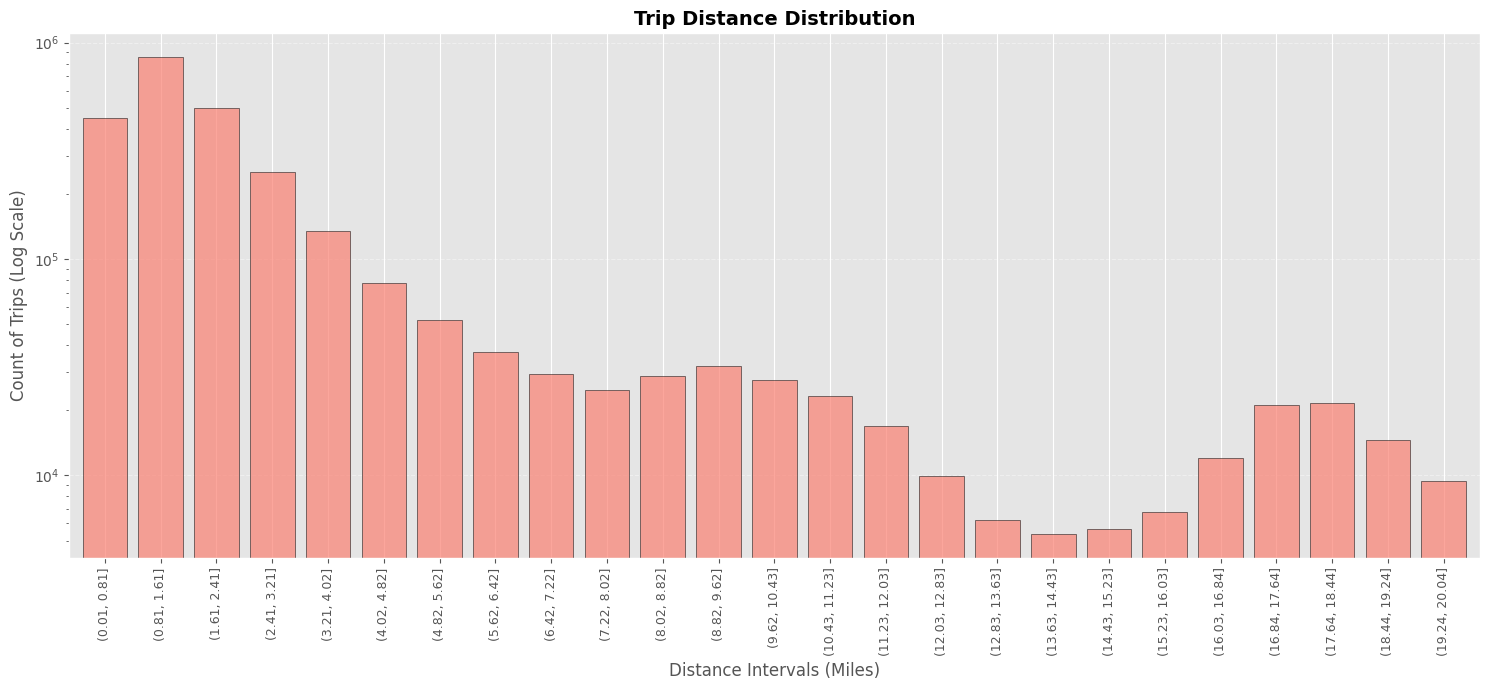

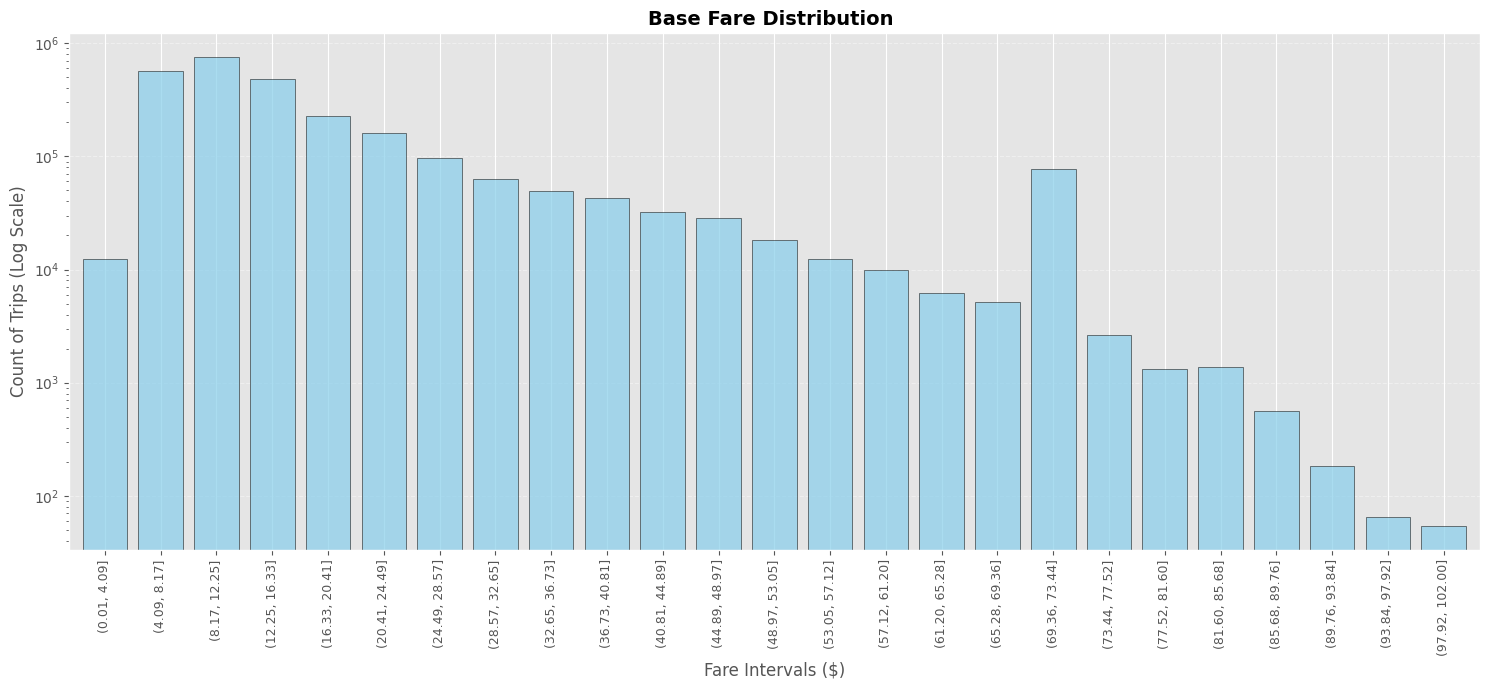

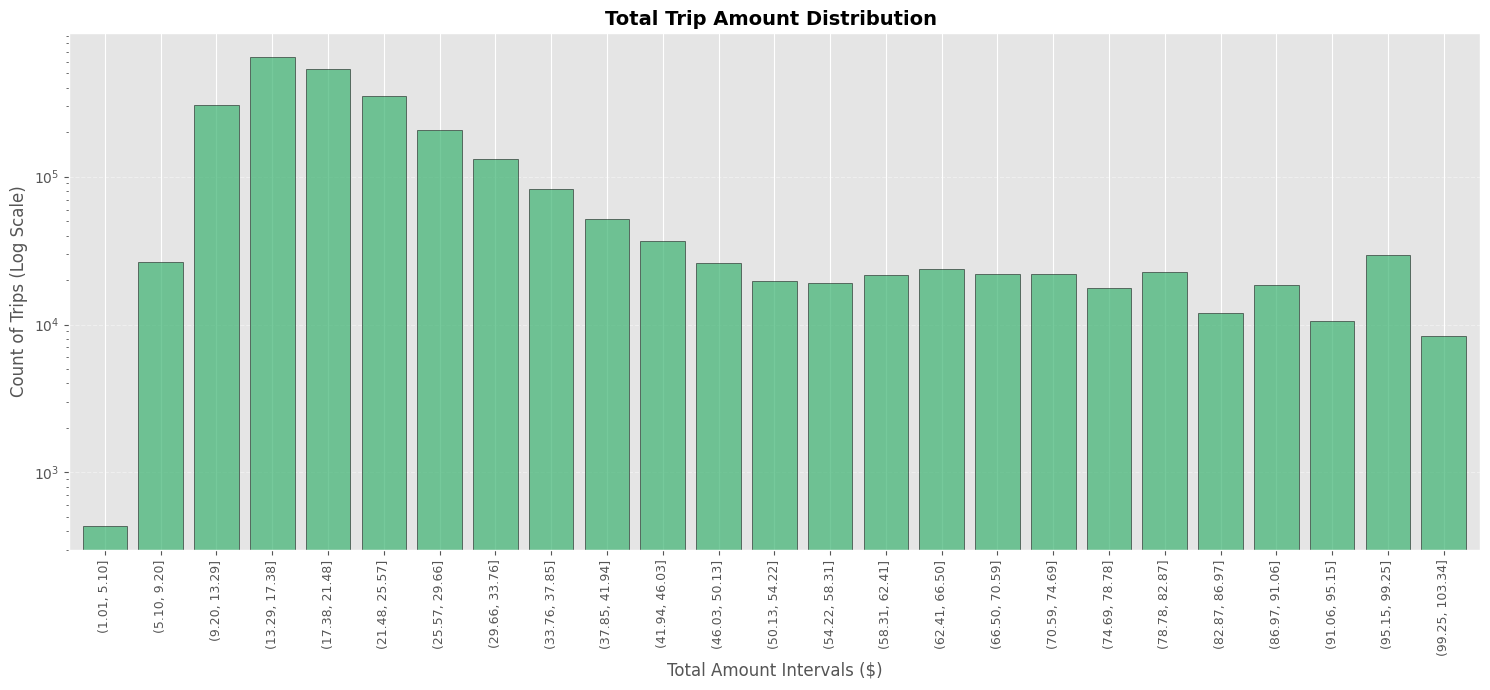

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set professional theme
plt.style.use('ggplot')

def plot_distribution_precision(data, column, bins, title, xlabel, color):
    """
    Plots a distribution with bin labels strictly formatted to 3 decimal places.
    """
    plt.figure(figsize=(15, 7))
    
    # 1. Define exact boundaries
    col_min = data[column].min()
    col_max = data[column].max()
    
    # 2. Create custom bin edges
    custom_bins = np.linspace(col_min, col_max, bins + 1)
    
    # 3. Categorize data
    binned_data = pd.cut(data[column], bins=custom_bins, include_lowest=True)
    
    # Count frequencies
    counts = binned_data.value_counts().sort_index()
    
    # 4. Format the index to show exactly 3 decimal places
    # This removes long strings like 1.009000000000001
    counts.index = counts.index.map(lambda x: f"({x.left:.2f}, {x.right:.2f}]")
    
    # 5. Generate the Plot
    counts.plot(kind='bar', color=color, edgecolor='black', alpha=0.7, width=0.8)
    
    # Log scale for better visibility of rare segments
    plt.yscale('log')
    
    # Formatting
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Count of Trips (Log Scale)', fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

# --- Execute Precision Visuals ---

# 1. Trip Distance Distribution
plot_distribution_precision(df_cleaned, 'trip_distance', 25, 
                          'Trip Distance Distribution', 
                          'Distance Intervals (Miles)', 'salmon')

# 2. Base Fare Amount Distribution
plot_distribution_precision(df_cleaned, 'fare_amount', 25, 
                          'Base Fare Distribution ', 
                          'Fare Intervals ($)', 'skyblue')

# 3. Total Amount Distribution
plot_distribution_precision(df_cleaned, 'total_amount', 25, 
                          'Total Trip Amount Distribution ', 
                          'Total Amount Intervals ($)', 'mediumseagreen')

## 🧮 Feature Engineering: Next-Mile Fare Calculation

To simulate taximeter behavior where the fare increments at the start of each new mile, we use the **Ceiling Function**. This ensures that any fraction of a mile is treated as a full mile for the unit price calculation.

###  Modified Formula:
$$\text{Fare per Mile} = \frac{\text{fare\_amount}}{\lceil \text{trip\_distance} \rceil}$$

* **Logic:** We use `np.ceil` to find the "Next Integer" (e.g., $1.1$ miles becomes $2.0$).
* **Precision:** Results are displayed and visualized with **3 decimal places**.

--- Adjusted Fare per Mile (Next-Mile Logic) ---


,fare_amount,trip_distance,fare_per_mile
0,17.7,1.72,8.850
1,10.0,1.80,5.000
2,23.3,4.70,4.660
3,10.0,1.40,5.000
4,7.9,0.80,7.900
5,29.6,4.70,5.920
6,45.7,10.82,4.155
8,31.0,5.44,5.167
9,3.0,0.04,3.000
10,7.9,0.75,7.900


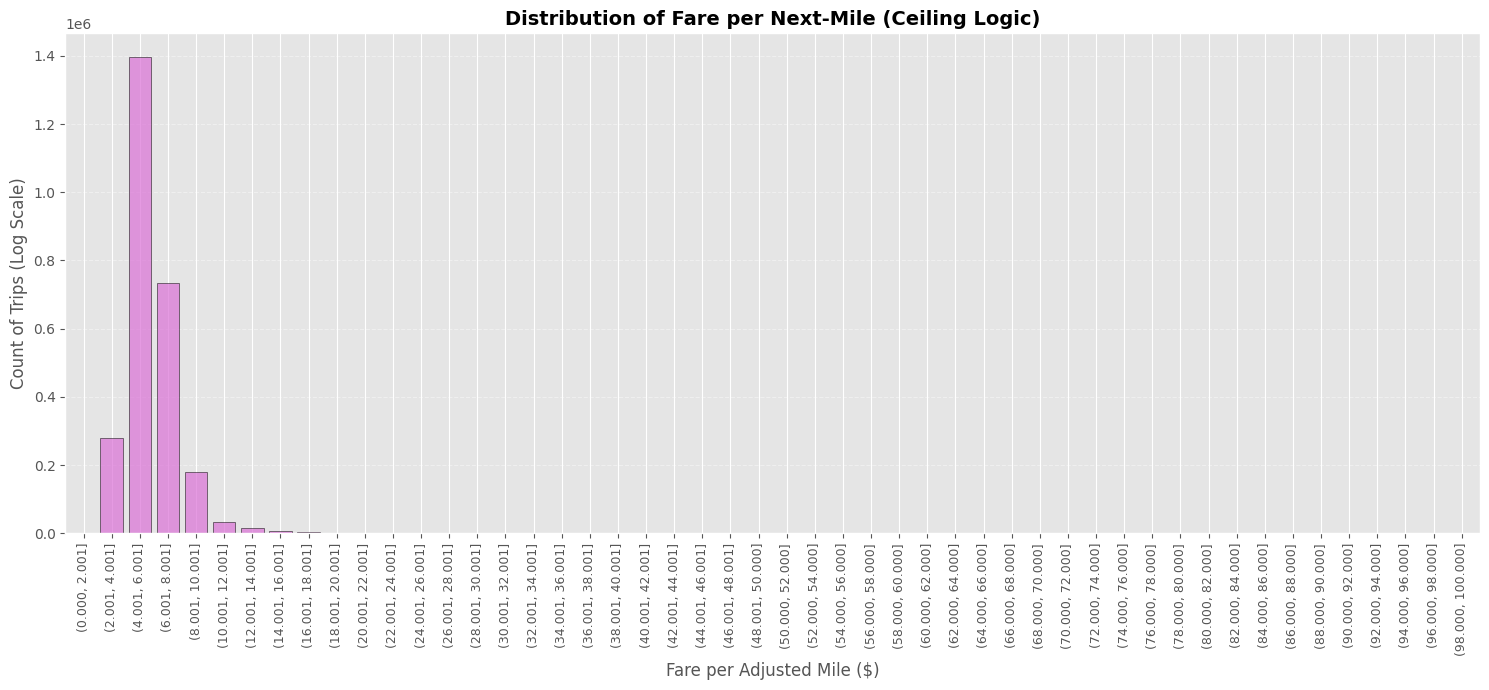

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Apply the Next-Integer (Ceiling) Logic
# np.ceil ensures that 1.1 miles becomes 2.0, representing the start of the next mile
df_cleaned['fare_per_mile'] = df_cleaned['fare_amount'] / np.ceil(df_cleaned['trip_distance'])

# 2. Safety Check: Remove any potential infinity values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna(subset=['fare_per_mile'])

# 3. Verification: Display high-precision results
print("--- Adjusted Fare per Mile (Next-Mile Logic) ---")
display(df_cleaned[['fare_amount', 'trip_distance', 'fare_per_mile']].head(10).round(3))

# 4. Visualization with 3-decimal formatting
def plot_distribution_final(data, column, bins, title, xlabel, color, with_log = True):
    plt.figure(figsize=(15, 7))
    col_min, col_max = data[column].min(), data[column].max()
    custom_bins = np.linspace(col_min, col_max, bins + 1)
    
    binned_data = pd.cut(data[column], bins=custom_bins, include_lowest=True)
    counts = binned_data.value_counts().sort_index()
    
    # Precise 3-decimal formatting for X-axis labels
    counts.index = counts.index.map(lambda x: f"({x.left:.3f}, {x.right:.3f}]")
    
    counts.plot(kind='bar', color=color, edgecolor='black', alpha=0.7, width=0.8)
    if with_log:
        plt.yscale('log')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Count of Trips (Log Scale)', fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Execute high-precision plot
plot_distribution_final(
    df_cleaned, 
    'fare_per_mile', 
    bins=50, 
    title='Distribution of Fare per Next-Mile (Ceiling Logic)', 
    xlabel='Fare per Adjusted Mile ($)', 
    color='orchid',
    with_log = False
)

##  Statistical Refinement: Handling Fare per Mile Outliers

After calculating the **Fare per Mile**, it is common to find extreme outliers (e.g., trips charged $100 for a 0.1-mile distance). To ensure our analysis remains representative of typical NYC taxi behavior, we apply a **99th Percentile Filter** to this new feature.

###  Optimization Steps:
1. **Calculate Threshold:** Determine the 99th percentile ($Q_{0.99}$) for `fare_per_mile`.
2. **Filter Extremes:** Remove records that exceed this threshold.
3. **Consistency:** This mirrors the logic previously applied to `trip_distance` and `total_amount`.
 
After removing the extreme top 1% of outliers, we perform a detailed statistical analysis of the **Fare per Mile** feature. This allows us to understand the typical cost density of a trip and the variance in pricing across the dataset.

###  Key Metrics Calculated:
* **Average (Mean):** The central tendency of the cost per mile.
* **Standard Deviation (STD):** The spread or dispersion of the pricing.
* **Minimum & Maximum:** The full range of valid unit prices after cleaning.
* **Final Visualization:** A distribution plot with 10 bins and a linear scale to observe the most common price points.

--- Fare per Mile Statistical Analysis ---
Average (Mean):      $5.745
Standard Deviation:  1.593
Minimum:             $0.001
Maximum:             $12.100
----------------------------------------
99th Percentile Threshold: $12.100
Remaining Records:         2,630,895


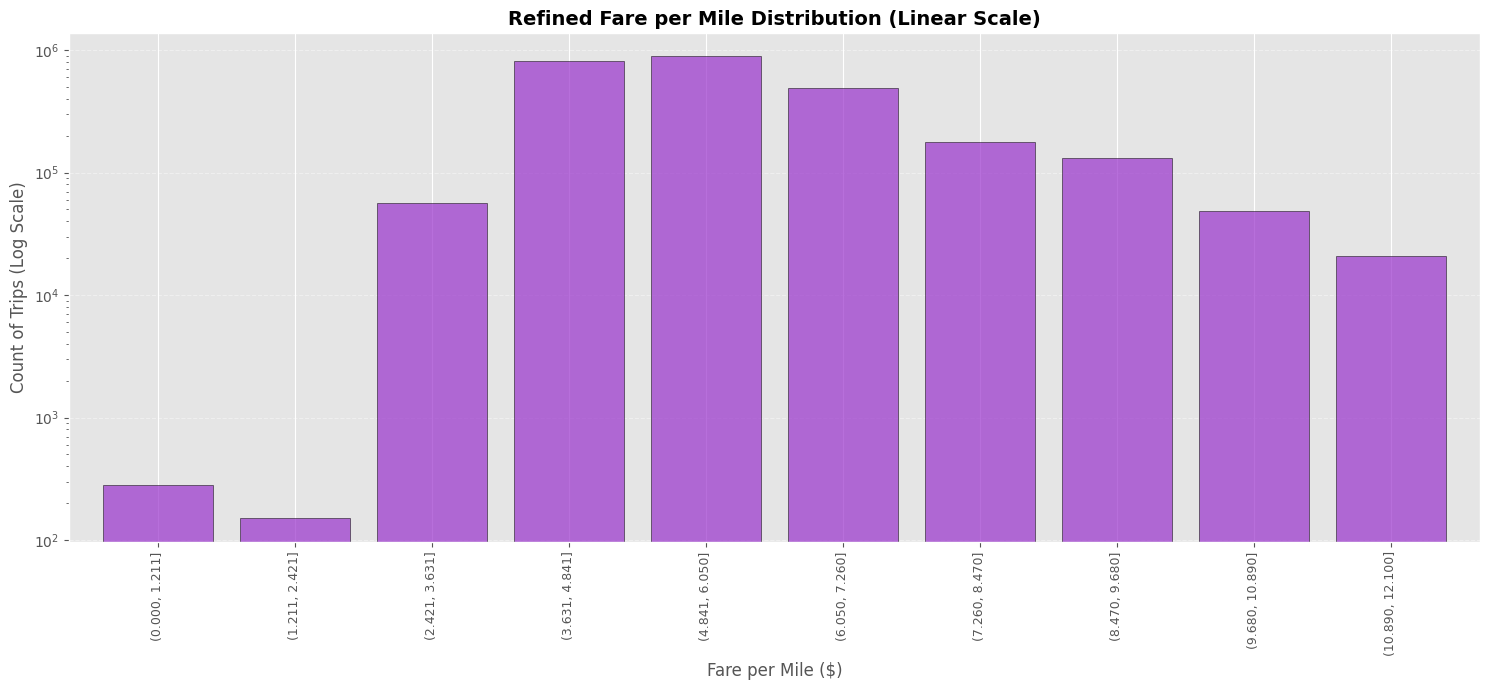

,count,mean,std,min,25%,50%,75%,max
fare_per_mile,2630895.0,5.745,1.593,0.001,4.575,5.35,6.5,12.1


In [104]:
import pandas as pd
import numpy as np

# 1. Calculate the 99th percentile threshold
fpm_threshold = df_cleaned['fare_per_mile'].quantile(0.99)

# 2. Filter the dataframe to remove outliers
df_cleaned = df_cleaned[df_cleaned['fare_per_mile'] <= fpm_threshold].copy()

# 3. Calculate requested statistics
fpm_avg = df_cleaned['fare_per_mile'].mean()
fpm_std = df_cleaned['fare_per_mile'].std()
fpm_min = df_cleaned['fare_per_mile'].min()
fpm_max = df_cleaned['fare_per_mile'].max()

# 4. Report the results with 3 decimal precision
print("--- Fare per Mile Statistical Analysis ---")
print(f"Average (Mean):      ${fpm_avg:.3f}")
print(f"Standard Deviation:  {fpm_std:.3f}")
print(f"Minimum:             ${fpm_min:.3f}")
print(f"Maximum:             ${fpm_max:.3f}")
print("-" * 40)
print(f"99th Percentile Threshold: ${fpm_threshold:.3f}")
print(f"Remaining Records:         {len(df_cleaned):,}")

# 5. Final Distribution Plot (Linear Scale as requested)
# Note: Ensure the function 'plot_distribution_final' is defined in your notebook
plot_distribution_final(
    data=df_cleaned, 
    column='fare_per_mile', 
    bins=10, 
    title='Refined Fare per Mile Distribution (Linear Scale)', 
    xlabel='Fare per Mile ($)', 
    color='darkorchid'
)


# Display the standard Pandas summary table
display(df_cleaned[['fare_per_mile']].describe().round(3).T)

##  Fine-Tuning: Removing Low-End Outliers

Based on the statistical summary, the minimum value ($0.001$) is logically impossible for a taxi service. This indicates data corruption or incomplete records. We will now apply a lower-bound filter to ensure every mile has a minimum realistic cost.

###  Filter Criteria:
* **Lower Bound:** `fare_per_mile` must be $\ge 2.5$ (Reflecting the standard NYC initial drop rate).

--- Final Polished Statistics (No Low-End Outliers) ---
New Minimum: $2.500
New Average: $5.746
Total Records: 2,630,449


,count,mean,std,min,25%,50%,75%,max
fare_per_mile,2630449.0,5.746,1.591,2.5,4.575,5.35,6.5,12.1


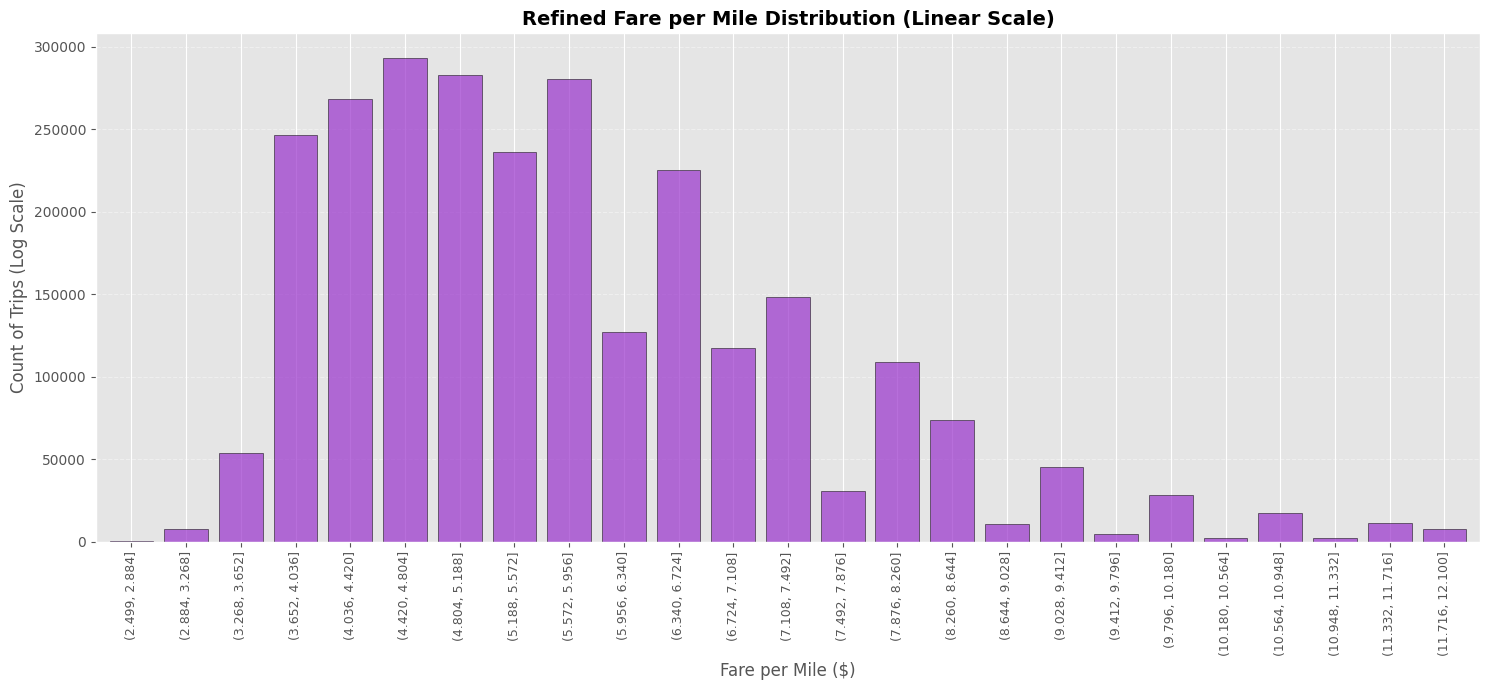

In [105]:
# 1. Apply lower bound filter (Removing values < $2.5)
df_cleaned = df_cleaned[df_cleaned['fare_per_mile'] >= 2.5].copy()

# 2. Recalculate Final Statistics
stats = df_cleaned['fare_per_mile'].describe().round(3)

print("--- Final Polished Statistics (No Low-End Outliers) ---")
print(f"New Minimum: ${stats['min']:.3f}")
print(f"New Average: ${stats['mean']:.3f}")
print(f"Total Records: {int(stats['count']):,}")

# 3. Final Verification Table
display(df_cleaned[['fare_per_mile']].describe().round(3).T)

plot_distribution_final(
    data=df_cleaned, 
    column='fare_per_mile', 
    bins=25, 
    title='Refined Fare per Mile Distribution (Linear Scale)', 
    xlabel='Fare per Mile ($)', 
    color='darkorchid',
    with_log = False
)

### ⏱️ Temporal Processing & Duration Filtering

We refine the temporal attributes by converting timestamps and calculating the **Trip Duration** in minutes. To maintain data integrity, we filter out logically impossible durations (e.g., negative times or trips lasting less than a minute).

--- Trip Duration Summary (Minutes) ---


,count,mean,std,min,25%,50%,75%,max
trip_duration,2599399.0,13.633,9.087,1.0,7.083,11.25,17.7,53.233


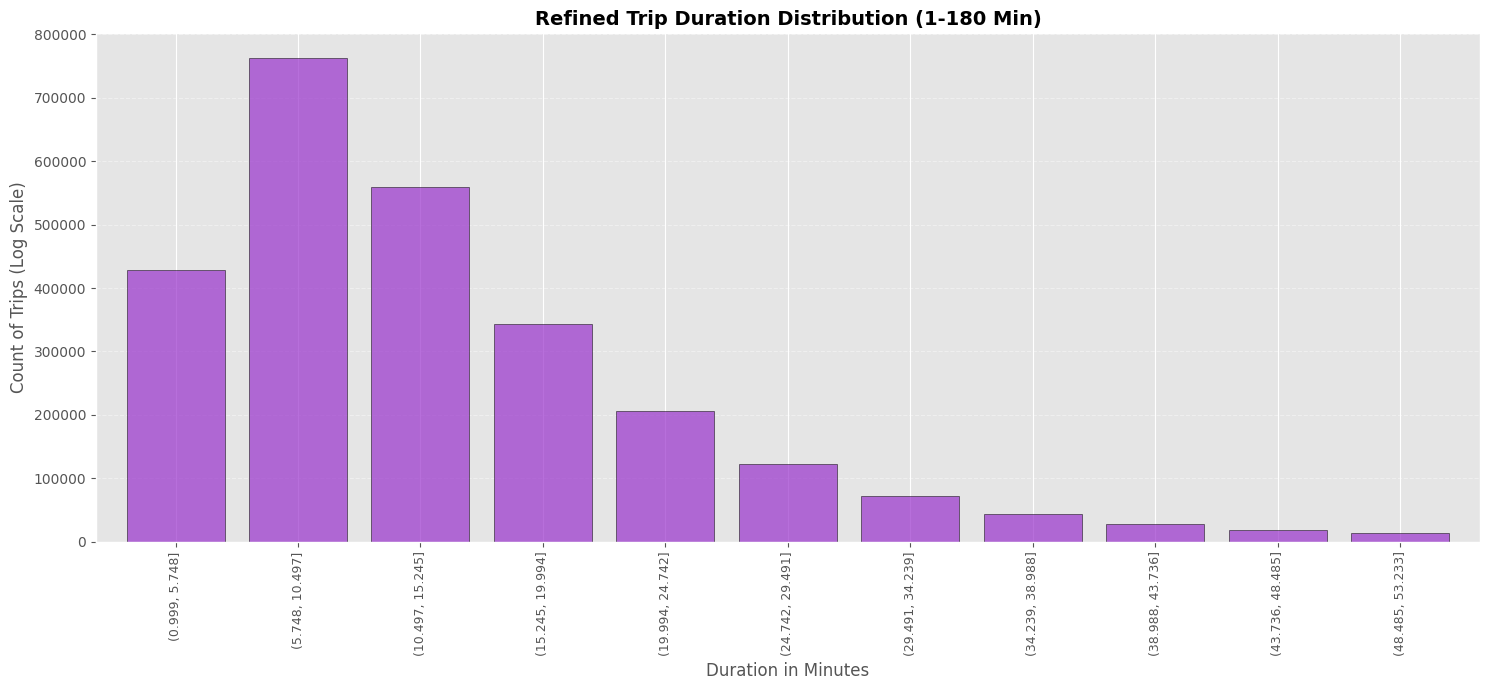

In [106]:
import pandas as pd
import numpy as np

# 1. Convert to datetime objects
df_cleaned['tpep_pickup_datetime'] = pd.to_datetime(df_cleaned['tpep_pickup_datetime'])
df_cleaned['tpep_dropoff_datetime'] = pd.to_datetime(df_cleaned['tpep_dropoff_datetime'])

# 2. Calculate trip duration in minutes
df_cleaned['trip_duration'] = (df_cleaned['tpep_dropoff_datetime'] - df_cleaned['tpep_pickup_datetime']).dt.total_seconds() / 60

percentile_trip_duration = 0.99
# 1. Calculate the 99th percentile threshold for trip_duration
duration_threshold = df_cleaned['trip_duration'].quantile(percentile_trip_duration)

# 2. Filter the dataframe to remove the top 1% outliers
df_cleaned = df_cleaned[df_cleaned['trip_duration'] <= duration_threshold].copy()



# 3. Apply logic filtering (1 min to 3 hours)
duration_mask = (df_cleaned['trip_duration'] >= 1.0) & (df_cleaned['trip_duration'] <= 180.0)
df_cleaned = df_cleaned[duration_mask].copy()

# 4. Display Summary Statistics with 3 decimal precision
print("--- Trip Duration Summary (Minutes) ---")
display(df_cleaned[['trip_duration']].describe().round(3).T)

# 5. Visualize using your specific function
plot_distribution_final(
    data=df_cleaned, 
    column='trip_duration', 
    bins=11, 
    title='Refined Trip Duration Distribution (1-180 Min)', 
    xlabel='Duration in Minutes', 
    color='darkorchid',
    with_log=False
)

##  Final Data Export & Efficiency Audit

With the cleaning and feature engineering complete, we are now exporting the final dataset. This section performs a comparative analysis between the **Raw** and **Cleaned** datasets to quantify the impact of our preprocessing.

###  Audit Metrics:
* **Storage Optimization:** Comparison of file sizes in Megabytes (MB).
* **Row Retention:** Tracking the number of records removed as outliers or invalid data.
* **Loss Percentage:** Calculating exactly how much "noise" was filtered out.

In [107]:
import os
import pandas as pd

# 1. Define Export Path
cleaned_csv_path = csv_path.replace('.csv', '_cleaned.csv')

# 2. Save the cleaned dataset
df_cleaned.to_csv(cleaned_csv_path, index=False)

# 3. Calculate Sizes (MB)
original_size = os.path.getsize(csv_path) / (1024 * 1024)
cleaned_size = os.path.getsize(cleaned_csv_path) / (1024 * 1024)

# 4. Calculate Row Counts
original_rows = pd.read_csv(csv_path).shape[0] # Reading count from original file
cleaned_rows = len(df_cleaned)

# 5. Calculate Percentages
retention_pct = (cleaned_rows / original_rows) * 100
loss_pct = 100 - retention_pct

# 6. Print Professional Audit Report
print("="*50)
print("📊 FINAL CLEANING AUDIT REPORT")
print("="*50)
print(f"{'Metric':<25} | {'Original':<12} | {'Cleaned':<12}")
print("-" * 55)
print(f"{'File Size (MB)':<25} | {original_size:>10.2f} | {cleaned_size:>10.2f}")
print(f"{'Total Row Count':<25} | {original_rows:>10,} | {cleaned_rows:>10,}")
print("-" * 55)
print(f"✅ Data Retention Rate:  {retention_pct:.2f}%")
print(f"❌ Data Reduction (Loss): {loss_pct:.2f}%")
print("="*50)
print(f"💾 File Saved to: {cleaned_csv_path}")

C:\Users\User\AppData\Local\Temp\ipykernel_16776\2959276359.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  original_rows = pd.read_csv(csv_path).shape[0] # Reading count from original file


📊 FINAL CLEANING AUDIT REPORT
Metric                    | Original     | Cleaned     
-------------------------------------------------------
File Size (MB)            |     296.22 |     317.19
Total Row Count           |  2,964,624 |  2,599,399
-------------------------------------------------------
✅ Data Retention Rate:  87.68%
❌ Data Reduction (Loss): 12.32%
💾 File Saved to: ../data/raw/nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01_cleaned.csv
